# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this tutorial we show how to (approximately) solve binary combinatorial optimization problems, using the __Quantum Approximate Optimization Algorithm (QAOA)__, as introduced in Ref.[1]. 
The QAOA algorithm belongs to the class of __hybrid quantum algorithms__ (leveraging both classical as well as quantum compute), that are widely believed to be the working horse for the current __NISQ (noisy intermediate-scale quantum) era__.
In this NISQ era QAOA is also an emerging approach for benchmarking quantum devices and is a prime candidate for demonstrating a practical quantum speed-up on near-term NISQ device [1,4]. 
To validate our approach we benchmark our results with exact results as obtained from classical QUBO solvers. 

We provide a step-by-step walkthrough explaining the QAOA quantum algorithm and show how to build the corresponding parametrized quantum circuit ansatz using the ```Braket``` SDK, with simple modular building blocks (that can be re-used for other purposes). 
We use open-source off-the-shelf ```scipy``` optimizers for classical numerical optimization. 
While we demonstrate our proof-of-concept approach using classical simulators for circuit execution, our code could in principle be run on actual quantum hardware by simply changing the definition of the ```device``` object (provided that the gate set used in the ansatz is supported by the device, as is the case here for IonQ; for Rigetti we need to apply one more extra trick as shown below). 

In [1]:
import numpy as np
from braket.devices import LocalSimulator
from scipy.optimize import minimize

from braket.experimental.algorithms.qaoa import evaluate_circuit, evaluate_loss, qaoa

We are now all set to run some QAOA simulation experiments. 
First of all, you can play and experiment yourself with the number of qubits $N$. 
Secondly, you may also experiment with the classical optimizer. 
Since we are using an off-the-shelf, black-box ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```OPT_METHOD``` parameter below. 
Some popular options readily available within this library include *Nelder-Mead*, *BFGS* and *COBYLA*. 
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized QAOA ansatz wavefunction. 
To address this issue, we may run several optimization loops, starting from different random parameter seeds. 
While this brute-force approach does not provide any guarantee to find the global optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the simulator or QPU, respectively.
Finally, the optimization loop may require the execution of many individual quantum tasks (i.e., single circuit executions for fixed parameters). 
For example, when choosing the classical [Powell](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) optimizer for the graph considered here, we find $\sim 270$ cycles in the for loop. 
For the local simulator device chosen here by default this is not an issue, but if you run this algorithm on any QPU you may want to adjust the ```maxfev``` parameter to control the maximum allowed number function evaluations (compare comment in the next code block below).

In [2]:
n_qubits = 2
n_layers = 1
coupling_matrix = np.diag(np.ones(n_qubits - 1), 1)
coupling_matrix = np.random.rand(n_qubits, n_qubits)
for i in range(n_qubits):
    coupling_matrix[i, i] = 0  # remove diagonal elements
print(coupling_matrix)

[[0.         0.53772796]
 [0.72018496 0.        ]]


In [3]:
circ = qaoa(n_qubits, n_layers, coupling_matrix)
print(circ)

T  : |0|1|              2              |3|4|              5              |6|     7      |          Result Types           |
                                                                                                                           
q0 : -H-C-------------------------------C-X-Rz(0.720184963930878*gamma_0)-X-Rx(2*beta_0)-Expectation(Z@Z)-Expectation(Z@Z)-
        |                               | |                               |              |                |                
q1 : -H-X-Rz(0.537727962110326*gamma_0)-X-C-------------------------------C-Rx(2*beta_0)-Expectation(Z@Z)-Expectation(Z@Z)-

T  : |0|1|              2              |3|4|              5              |6|     7      |          Result Types           |

Unassigned parameters: [beta_0, gamma_0].


In [4]:
idx = coupling_matrix.nonzero()
js = [coupling_matrix[qubit_pair] for qubit_pair in zip(idx[0], idx[1])]
print(js)

[0.5377279621103259, 0.7201849639308777]


In [5]:
device = LocalSimulator()

losses = []


def loss(values, device, circ, shots, js):
    global losses
    task = evaluate_circuit(device, circ, values, shots=shots)
    loss = evaluate_loss(task, js)
    losses.append(loss)
    return loss


# set bounds for search space
init_values = np.random.rand(2 * n_layers)

bounds = [(0, 2 * np.pi) for _ in range(2 * n_layers)]

In [6]:
result = minimize(
    loss,
    init_values,
    args=(device, circ, 0, js),
    options={"disp": True, "maxfev": 150},
    method="Nelder-Mead",
    bounds=bounds,
)

Optimization terminated successfully.
         Current function value: -1.257913
         Iterations: 36
         Function evaluations: 70


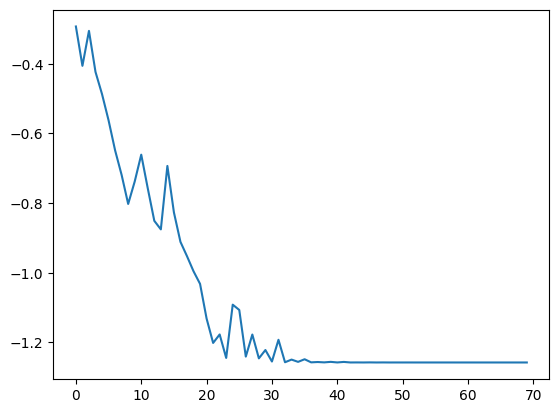

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses)